<h3> HANDY PYTHON PACKAGES </h3>

In [144]:
import requests
import json
from random import randint
import math
import pandas as pd
from IPython.display import display, HTML, JSON
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
import datetime
import shapely
from shapely.geometry import box
from matplotlib.patches import Polygon
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

<H3> AUXILIARY FUNCTIONS </H3>

In [145]:
def get_url_addon(params):
    """
    Concatenates the params and their values in an unique string to later be attached to the generic API ENDPOINTS
    This function expects as argument and object with as many keys and values as conditions 
    the user want the data-sources to meet:
        params = {
            'initial_datetime':[],
            'end_datetime':[],
            'standard_variable':[],
            'bbox': [min. lat., max. lat., min. lon., max. lon]
            'elevation_range': [min. elevation, max. elevation. ],
            'processing_level':[],
            'feature_type':[],
            'resample_rule':[],
            'resample_how':[],
            'max_qc_value':[]
        }

    """    
    url_addon = ''
    for key in params:
        if key == 'bbox' or key == 'elevation_range':
            url_addon = url_addon+'&'+key+'='+','.join(params[key])
            continue
        for item in params[key]:
            url_addon = url_addon+'&'+key+'='+item
    return '?'+url_addon[1:len(url_addon)] 

In [146]:
def render_data_overview(response):
    cols = ['proc level','type','coordinates','standard_name','parameter']; numb = 0; rows = []; values = []
    for key in response.keys():
        for feature in response[key]['features']:
            for variable in feature['variables']:
                for param in feature['variables'][variable].keys():
                    #data = ','.join(str(e) for e in feature['variables'][variable][param]['data'][:10]) 
                    #units = feature['variables'][variable][param]['units']
                    #precision = feature['variables'][variable][param]['precision']
                    rows.append(numb)    
                    values.append([key,feature['feature_type'],','.join(feature['coordinates'].keys()),variable,param])
                    numb = numb +1
    return [values,rows,cols]

In [147]:
def get_parameter(response, parameter):
    for key in response.keys():
        for feature in response[key]['features']:
            for variable in feature['variables']:
                for param in feature['variables'][variable].keys():
                    if param == parameter:
                        data = feature['variables'][variable][param]['data']
                        #units = feature['variables'][variable][param]['units']
                        #precision = feature['variables'][variable][param]['precision']
                        coordinates = ','.join(feature['coordinates'].keys())
                        return [data, coordinates]

In [148]:
def get_coordinate(response, coordinate):
    for key in response.keys():
        for feature in response[key]['features']:
            for coordinates in feature['coordinates'].keys():
                if coordinates == coordinate:
                    data = feature['coordinates'][coordinate]['data']
                    #units = feature['coordinates'][coordinate]['units']                      
                    return [data] #, units

<H3> PREREQUISITES</H3>

In [6]:
api_key = '' #write you SOCIB api_key
api_url = 'http://api.socib.es'
headers = {
    'accept': 'application/vnd.socib+json',
    'api_key': api_key,
}

<H3>SELECTING A DATA-SOURCE'S DATA WITH PARAMS</H3>

The data-source/{id}/data/ ENDPOINT not only returns all data associated to a given deployment (id), but also allows users to filter the generic answer and retain only the data meeting certain conditions and  even process the data at some extent. These filtering and processing is feasible thanks to the data-source/{id}/data/ ENDPOINT PARAMS:

<ul><li>initial_datetime</li> 
    <ul>UTC time as YYYY-MM-DDTHH:MM:SS</ul>
</ul>
<ul><li>end_datetime</li> 
    <ul>UTC time as YYYY-MM-DDTHH:MM:SS</ul>
</ul>
<ul><li>standard_variable</li> 
    <ul>Any value of those returned by <a href="https://github.com/pazrg/SOCIB_API/blob/master/tips/quick_start.ipynb" target="_blank">/standard-variables/ ENDPOINT</a></ul>
</ul>
<ul><li>bbox</li>
    <ul>Area where a given deployment has been operating since deployed (released or placed). Area should be specify as a 4 comma-separated float numbers following the structure: min. lat., max. lat., min. lon., max. lon</ul>
</ul>
<ul><li>elevation_range</li>
    <ul>2 comma-separated float following the structure: min. elevation, max. elevation.</ul>
</ul>
<ul><li>processing_level</li>
    <ul>The processing level of the data to be returned. The format should be {number_of_level}. L0 means raw data, L1 means data including derived parameters and QC applied.
</ul>
</ul>
<ul><li>feature_type</li>
    <ul>Any value of those returned by <a href="https://github.com/pazrg/SOCIB_API/blob/master/tips/quick_start.ipynb" target="_blank">/data-types/ ENDPOINT</a></ul>
</ul>
</ul>
<ul><li>resample_rule</li>
    <ul>The time frequency to be used in order to resample the result data. The values of this parameter handled by Pandas library. This full values list can be found in the pandas time offset aliases docs (http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases). Some examples would be: how=1d, how=1w or how=1AS.</ul>
</ul>
<ul><li>resample_how</li>
    <ul>The method to be used in order to _resample_and_interpolate the result data. The values of this parameter handled by Pandas library. This possible values of this parameter are: sum, mean, std, sem, max, min, median, first, last, ohlc.</ul>
</ul>
<ul><li>max_qc_value</li>
    <ul>Provide only the values of each variable whose corresponding QC value is better or equal (less or equal) than the given value. The values whose QC values are greater than the given value will be switched by null.
</ul>
</ul>
</ul>

Let's choose again a random data-source and filter its generic /data-source/{id}/data/ response:

In [33]:
end_point = '/data-sources/'
request = requests.get('%s%s' % (api_url, end_point), headers=headers)
response = json.loads(request.text)

random = randint(0,response['count']-1) #random deployment
frac, whole = math.modf(float(random)/8) #there is a pagination of 8 deployments (position 0, 1, 2, 3, 4, 5, 6, 7)
page = int(whole) + 1
position = int(8 - ((page*8) - random))
print('i.e Deployment number %s is on page %s at position %s'%(random,page,position))

i.e Deployment number 40 is on page 6 at position 0


In [34]:
#requesting the page where the deployment is
end_point = '/data-sources/'
page_request = requests.get('%s%s?%s' % (api_url, end_point, 'page='+str(page)), headers=headers)
print('Requested url: '+'%s%s?%s' % (api_url, end_point, 'page='+str(page)))
page_response = json.loads(page_request.text)

#accessing the targeted deployment:
targeted_deployment = page_response['results'][position]

#info of the targeted deployment  into table
df = pd.DataFrame(targeted_deployment.values(), index=targeted_deployment.keys(), columns=['deployment '+targeted_deployment['id']])
df.style

Requested url: http://api.socib.es/data-sources/?page=6


If we are interested only in quality checked data (L1) we can ask for it explicity:

In [36]:
#searching criteria
deployment_id = targeted_deployment['id']
end_point = '/data-sources/'+deployment_id+'/data/'
params = {
    'processing_level':['L1'],
} 
#request
request = requests.get('%s%s%s' % (api_url, end_point,get_url_addon(params)), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s%s' % (api_url, end_point,get_url_addon(params)))

#info of the targeted deploymentinto table
[values, rows, cols] = render_data_overview(response)
df = pd.DataFrame(values, index=rows, columns=cols)
display(df.style)

Requested url: http://api.socib.es/data-sources/9fa206a1b3/data/?processing_level=L1


If we already know which variable(s) we want from all the available we can again, explicity ask for it and forget about the others:

In [39]:
deployment_id = targeted_deployment['id']

#requesting the deployment's data by id
end_point = '/data-sources/'+deployment_id+'/data/'
params = {
    'processing_level':['L1'],
    'standard_variable':['sea_water_temperature','sea_water_practical_salinity'],
} 
#request
request = requests.get('%s%s%s' % (api_url, end_point,get_url_addon(params)), headers=headers)
response = json.loads(request.text)
print('Requested url: '+('%s%s%s' % (api_url, end_point,get_url_addon(params))).replace (" ","%20"))

[values, rows, cols] = render_data_overview(response)
df = pd.DataFrame(values, index=rows, columns=cols)
display(df.style)

Requested url: http://api.socib.es/data-sources/9fa206a1b3/data/?processing_level=L1&standard_variable=sea_water_temperature&standard_variable=sea_water_practical_salinity


This way, users can reduce the amount of data retrieved from the whole originaly available in a specific data-source (deployment) and work only with the ones they are interested in:

In [124]:
#variables
temp = get_parameter(response,'WTR_TEM_01')[0]
temp = np.array(temp,dtype=float)
salt = get_parameter(response,'SALT_01')[0]
salt = np.array(salt,dtype=float)
#coordinates
lon = get_coordinate(response,'longitude')[0]
lat = get_coordinate(response,'latitude')[0]
time = get_coordinate(response,'time')[0]
depth = get_coordinate(response,'depth')[0]
lat = np.array(lat,dtype=float)
lon = np.array(lon,dtype=float)
depth = np.array(depth,dtype=float)

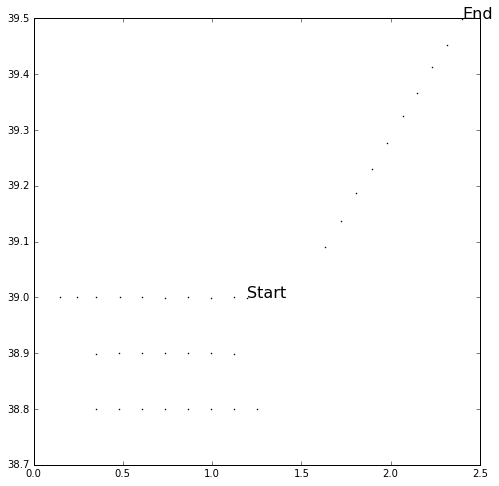

In [125]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.plot(lon, lat, 'ko', ms=1)
plt.text(lon[0], lat[0], 'Start', fontsize=16)
plt.text(lon[-1], lat[-1], 'End', fontsize=16)
plt.show()

In [126]:
lonmin, lonmax = ax.get_xlim()
latmin, latmax = ax.get_ylim()
cmap = plt.cm.Spectral_r
whole_temp = np.concatenate(temp,axis=0)
norm = colors.Normalize(vmin=min(whole_temp), vmax=max(whole_temp))

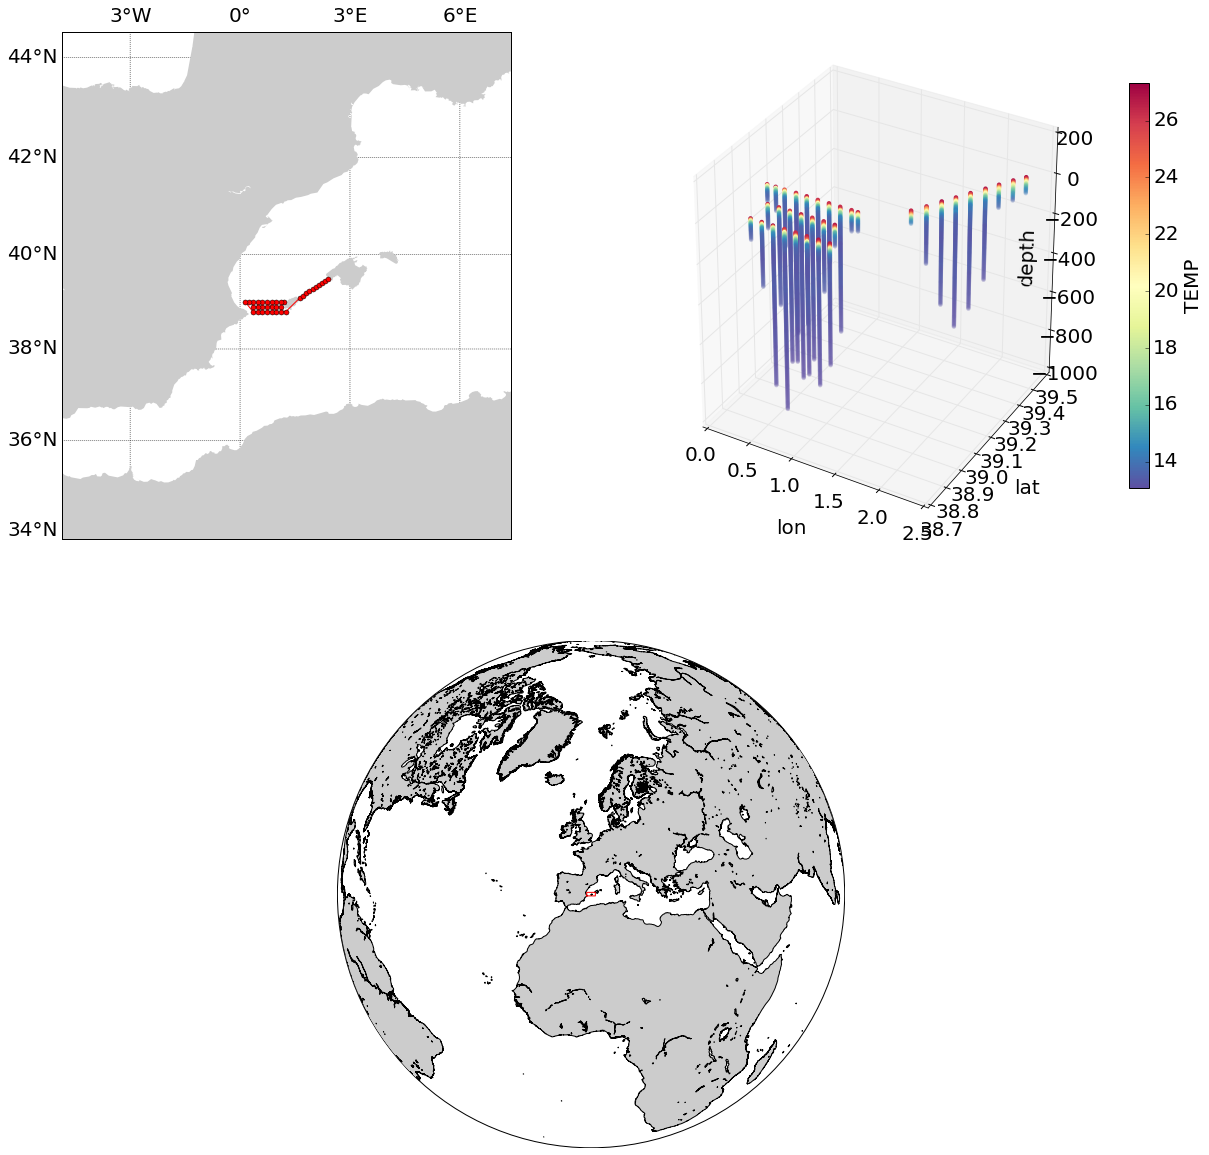

In [157]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(222, projection='3d')
for a in range(0, len(time)-1):
    plt.scatter(lon[a]*np.ones(len(depth[0])),lat[a]*np.ones(len(depth[0])), zs=-depth[a,:], zdir='z', s=20, c=temp[a,:], edgecolor='None', cmap=cmap, norm=norm)
    plt.tick_params(labelsize=20)
cb = plt.colorbar(fraction=0.040, cmap=cmap, norm=norm)
cb.ax.tick_params(labelsize=20) 
cb.set_label(label="TEMP", size=20)
ax.set_zlabel('depth',labelpad=-40,rotation=90,fontsize=20)
ax.set_ylabel('lat',labelpad=20,fontsize=20)
ax.set_xlabel('lon',labelpad=20,fontsize=20)

ax = fig.add_subplot(221)
m = Basemap(projection='merc', llcrnrlat=min(lat)-5, urcrnrlat=max(lat)+5,llcrnrlon=min(lon)-5, urcrnrlon=max(lon)+5, lat_ts=38., resolution='i')
m.fillcontinents(zorder=2)
m.drawparallels(np.arange(-90.,91.,2.), labels=[1,0,0,0], linewidth=0.5, zorder=1, fontsize=20)
m.drawmeridians(np.arange(-180.,181.,3.), labels=[0,0,1,0], linewidth=0.5, zorder=1, fontsize=20)
x,y = m(lon, lat)
m.plot(x,y, 'ro-', ms=5)

ax = fig.add_subplot(212)
bounding_box = shapely.geometry.box(lonmin, latmin, lonmax, latmax)
x = bounding_box.centroid.x
y = bounding_box.centroid.y
map = Basemap(projection='ortho',lat_0=y, lon_0=x,resolution='i')
map.drawmapboundary()
map.fillcontinents()
map.drawcoastlines()
xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
ys = [latmin,latmin,latmax,latmax,latmin]
map.plot(xs, ys,latlon = True, color='red')

plt.show()

What if I want now only the isolate transect? Let's ask for it using a bounding box!

In [180]:
deployment_id = targeted_deployment['id']
#requesting the deployment's data by id
end_point = '/data-sources/'+deployment_id+'/data/'
params = {
    'processing_level':['L1'],
    'standard_variable':['sea_water_temperature','sea_water_practical_salinity'],
    'bbox':[str(39.10),str(40.),str(0.),str(3.)]
} 
#request
request = requests.get('%s%s%s' % (api_url, end_point,get_url_addon(params)), headers=headers)
response = json.loads(request.text)
print('Requested url: '+('%s%s%s' % (api_url, end_point,get_url_addon(params))).replace (" ","%20"))

[values, rows, cols] = render_data_overview(response)
df = pd.DataFrame(values, index=rows, columns=cols)
display(df.style)

Requested url: http://api.socib.es/data-sources/9fa206a1b3/data/?bbox=39.1,40.0,0.0,3.0&processing_level=L1&standard_variable=sea_water_temperature&standard_variable=sea_water_practical_salinity


In [181]:
#variables
temp = get_parameter(response,'WTR_TEM_01')[0]
temp = np.array(temp,dtype=float)
salt = get_parameter(response,'SALT_01')[0]
salt = np.array(salt,dtype=float)
#coordinates
lon = get_coordinate(response,'longitude')[0]
lat = get_coordinate(response,'latitude')[0]
time = get_coordinate(response,'time')[0]
depth = get_coordinate(response,'depth')[0]
lat = np.array(lat,dtype=float)
lon = np.array(lon,dtype=float)
depth = np.array(depth,dtype=float)

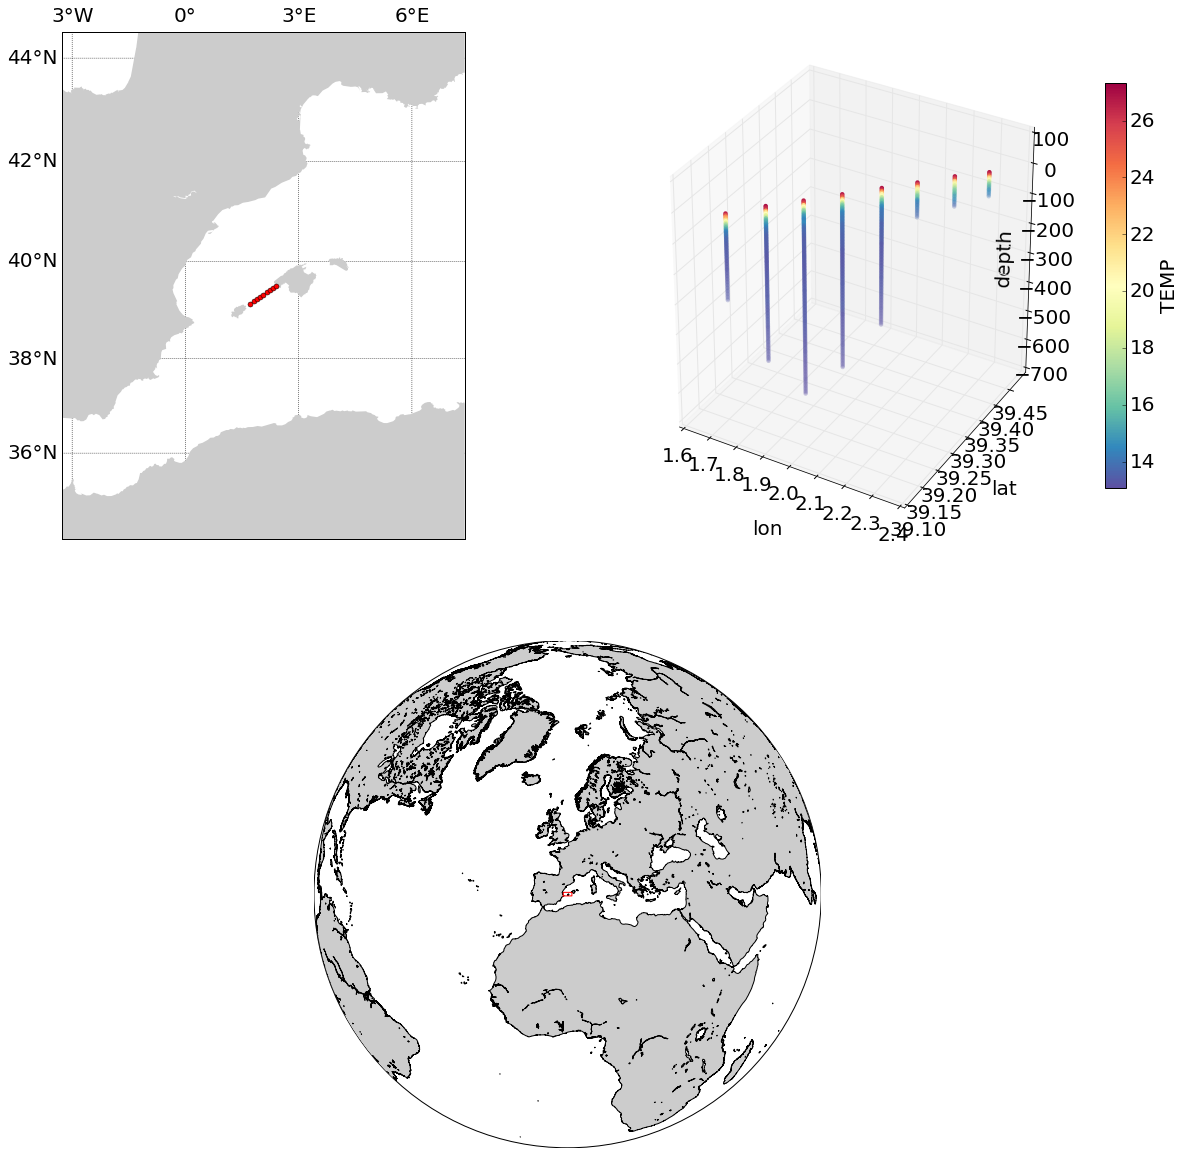

In [182]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(222, projection='3d')
for a in range(0, len(time)-1):
    plt.scatter(lon[a]*np.ones(len(depth[0])),lat[a]*np.ones(len(depth[0])), zs=-depth[a,:], zdir='z', s=20, c=temp[a,:], edgecolor='None', cmap=cmap, norm=norm)
    plt.tick_params(labelsize=20)
cb = plt.colorbar(fraction=0.040, cmap=cmap, norm=norm)
cb.ax.tick_params(labelsize=20) 
cb.set_label(label="TEMP", size=20)
ax.set_zlabel('depth',labelpad=-40,rotation=90,fontsize=20)
ax.set_ylabel('lat',labelpad=20,fontsize=20)
ax.set_xlabel('lon',labelpad=20,fontsize=20)

ax = fig.add_subplot(221)
m = Basemap(projection='merc', llcrnrlat=min(lat)-5, urcrnrlat=max(lat)+5,llcrnrlon=min(lon)-5, urcrnrlon=max(lon)+5, lat_ts=38., resolution='i')
m.fillcontinents(zorder=2)
m.drawparallels(np.arange(-90.,91.,2.), labels=[1,0,0,0], linewidth=0.5, zorder=1, fontsize=20)
m.drawmeridians(np.arange(-180.,181.,3.), labels=[0,0,1,0], linewidth=0.5, zorder=1, fontsize=20)
x,y = m(lon, lat)
m.plot(x,y, 'ro-', ms=5)

ax = fig.add_subplot(212)
bounding_box = shapely.geometry.box(lonmin, latmin, lonmax, latmax)
x = bounding_box.centroid.x
y = bounding_box.centroid.y
map = Basemap(projection='ortho',lat_0=y, lon_0=x,resolution='i')
map.drawmapboundary()
map.fillcontinents()
map.drawcoastlines()
xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
ys = [latmin,latmin,latmax,latmax,latmin]
map.plot(xs, ys,latlon = True, color='red')

plt.show()